# Analyze the Frequency Plot of the Signals

In [1]:
import os
import sys
import math
sys.path.append(os.path.join(os.getcwd().partition('Code')[0], "Code"))
from src.config_base import GeneralConfig

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator, FixedLocator
from matplotlib.lines import Line2D

In [3]:
from src.data.read_pickle import ReadPickle
from src.filtering.filter_methods import FilterMethods
from src.voltage_capacity_analysis.ica import ICA
from src.voltage_capacity_analysis.dva import DVA
from src.visualization.config_visualization import VisualizationConfig, instantiate_matplotlib_parameters, cm2inch
instantiate_matplotlib_parameters()
from src.visualization.colormaps import ColorMaps
from src.utils.bode_utils import Bode
from bode_utils import set_log_ticks

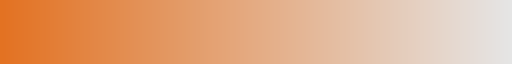

In [4]:
tum_orange_cmap = ColorMaps.orange_tum()
orange_colors = tum_orange_cmap(np.linspace(0,1, 10))
tum_orange_cmap

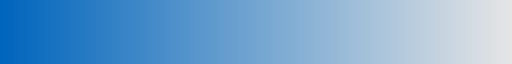

In [5]:
tum_blue_cmap = ColorMaps.blue_tum()
blue_colors = tum_blue_cmap(np.linspace(0,1, 10))
tum_blue_cmap

## Read tesla vehicle Files

In [6]:
path2files = os.path.join(GeneralConfig.path2data.value,"Tesla","vehicle")

In [7]:
def filter_func_preprocess_v_U(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [8]:
def filter_func_preprocess_v_Q(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [9]:
read_pickle = ReadPickle()

In [10]:
df_veh_tesla_unfiltered = read_pickle.read(os.path.join(path2files,"Tesla_JB_8A_CEE7_C57_2021.pkl"))

In [11]:
read_pickle.set_filter_U(filter_func_preprocess_v_U)
read_pickle.set_filter_Q(filter_func_preprocess_v_Q)

In [12]:
df_veh_tesla =  read_pickle.read(os.path.join(path2files,"Tesla_JB_8A_CEE7_C57_2021.pkl"))

# DVA

In [13]:
def filter_func(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [14]:
dva_extractor = DVA()
_, cropped_time_signal_raw_v =  dva_extractor.get_dva(time=df_veh_tesla_unfiltered["time_h"], capacity=df_veh_tesla_unfiltered["Q"], voltage=df_veh_tesla_unfiltered["U"],crop_cap_Ah=(1,180), soc_signal=df_veh_tesla_unfiltered["time_s"], soc_offset=0)
dva_raw_v, cap_raw_v =  dva_extractor.get_dva(time=df_veh_tesla_unfiltered["time_h"], capacity=df_veh_tesla_unfiltered["Q"], voltage=df_veh_tesla_unfiltered["U"],crop_cap_Ah=(1,180))

In [15]:
dva_extractor = DVA()
_ , cropped_time_signal_v =  dva_extractor.get_dva(time=df_veh_tesla["time_h"], capacity=df_veh_tesla["Q"], voltage=df_veh_tesla["U"],crop_cap_Ah=(1,180), soc_signal=df_veh_tesla["time_s"], soc_offset=0)
dva_pre_filt_v, cap_pre_filt_v =dva_extractor.get_dva(time=df_veh_tesla["time_h"], capacity=df_veh_tesla["Q"], voltage=df_veh_tesla["U"],crop_cap_Ah=(1,180))
dva_extractor.set_filter(filter_func)
dva_filt_v, cap_filt_v =dva_extractor.get_dva(time=df_veh_tesla["time_h"], capacity=df_veh_tesla["Q"], voltage=df_veh_tesla["U"],crop_cap_Ah=(1,180))

### Amplitude Data

In [16]:
#(time vector is the same for all signals and therefore unified for simplity)
time_vector_v = df_veh_tesla["time_s"]

In [17]:
timedelta_v =time_vector_v.diff().mean()
sample_frequency_v = round(float(1/timedelta_v),1)
print(sample_frequency_v)

0.1


In [18]:
print(timedelta_v)

10.0


In [19]:
### DVA
DVA_raw_v = Bode().get_bode_amplitude(time =cropped_time_signal_raw_v, signal =dva_raw_v, sample_frequency = sample_frequency_v)
DVA_pre_filt_v = Bode().get_bode_amplitude(time = cropped_time_signal_v, signal = dva_pre_filt_v, sample_frequency = sample_frequency_v)
DVA_filt_v = Bode().get_bode_amplitude(time = cropped_time_signal_v, signal = dva_filt_v, sample_frequency = sample_frequency_v)

## ICA

In [20]:
ica_extractor = ICA()
ica_extractor.set_filter(lambda x: x)
ica_raw_v, volt_raw_v = ica_extractor.get_ica(time=df_veh_tesla_unfiltered["time_h"], capacity=df_veh_tesla_unfiltered["Q"], voltage=df_veh_tesla_unfiltered["U"],crop_volt_V=(280,390),IQR_filter=False)

In [21]:
read_pickle = ReadPickle()
read_pickle.set_filter_U(filter_func_preprocess_v_U)
read_pickle.set_filter_Q(filter_func_preprocess_v_Q)

In [22]:
df_veh_tesla =  read_pickle.read(os.path.join(path2files,"Tesla_JB_8A_CEE7_C57_2022.pkl"))

In [23]:
def filter_func(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [24]:
ica_extractor = ICA()
ica_pre_filt_v, volt_pre_filt_v= ica_extractor.get_ica(time=df_veh_tesla["time_h"], capacity=df_veh_tesla["Q"], voltage=df_veh_tesla["U"],crop_volt_V=(280,390),IQR_filter=True)
ica_extractor.set_filter(filter_func)
#ica_extractor.set_post_filter(filter_func_v)
ica_filt_v, volt_filt_v = ica_extractor.get_ica(time=df_veh_tesla["time_h"], capacity=df_veh_tesla["Q"], voltage=df_veh_tesla["U"],crop_volt_V=(280,390),postfilter=False,postfilter_volt_range=(350,360))

### Amplitude Data

In [25]:
### ICA
ICA_raw_v = Bode().get_bode_amplitude(time =time_vector_v[0:len(ica_raw_v)], signal =ica_raw_v, sample_frequency = sample_frequency_v)
ICA_pre_filt_v = Bode().get_bode_amplitude(time = time_vector_v[0:len(ica_pre_filt_v)], signal = ica_pre_filt_v, sample_frequency = sample_frequency_v)
ICA_filt_v = Bode().get_bode_amplitude(time = time_vector_v[0:len(ica_filt_v)], signal = ica_filt_v, sample_frequency = sample_frequency_v)

In [26]:
ica_raw_v *= 1/100 * len(df_veh_tesla_unfiltered["time_h"]) # correct for non-filtered signal derivatives to filtered derivatives
ica_raw_v[(volt_raw_v<341)&(ica_raw_v>100)]=50 # make letter c) more visible

### Plots Veh

In [27]:
def DVA_plot_v(axes, cap_raw, dva_raw,
        cap_pre_filt, dva_pre_filt,
        cap_filt, dva_filt):
    Q_nom = 161
    # 6 Ah shift compared to cell
    axes.plot(cap_raw,dva_raw*Q_nom,color=VisualizationConfig.TUMgrau50.value,linewidth=0.8)
    axes.plot(cap_pre_filt,dva_pre_filt*Q_nom,color=VisualizationConfig.TUMhellblau.value)
    axes.plot(cap_filt,dva_filt*Q_nom,color=VisualizationConfig.TUMblau.value)
    axes.set_ylabel(r"$Q_{veh.}\cdot\frac{dU_{veh.}}{dQ_{veh.}}$ in V",fontsize=9)
    axes.set_xlabel(r"Vehicle charge in Ah",fontsize=9) 
    
    axes.set_ylim([0,106])
    tick_positions = np.array([0,27,54,81,106])
    axes.set_yticks(tick_positions)
    axes.set_xlim([0,161])
    tick_positions = np.array([0,40,80,120,161])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    
    axes.grid(color="gainsboro")
    axes.set_axisbelow(True)
    
    return axes

In [28]:
def DVA_bode_plot_v(axes,freq_raw, mag_raw,
             freq_pre_filt, mag_pre_filt,
             freq_filt,mag_filt):
    
    axes.grid(color="gainsboro",which="both")
    axes.set_axisbelow(True)
        
    axes.semilogx(freq_raw, mag_raw,color=VisualizationConfig.TUMgrau50.value)
    axes.semilogx(freq_pre_filt, mag_pre_filt,color=VisualizationConfig.TUMhellblau.value)
    axes.semilogx(freq_filt, mag_filt,color=VisualizationConfig.TUMblau.value)    
    axes.set_ylabel(r"Magnitude in dB",fontsize=9)
    axes.set_xlabel(r"Frequency in Hz",fontsize=9) 
    
    axes.set_ylim([0,140])
    tick_positions = np.array([0,20,40,60,80,100,120,140])
    axes.set_yticks(tick_positions)
    
    axes.set_xlim([0.000001,0.1])
    tick_positions = np.array([0.000001,0.00001,0.0001,0.001,0.01,0.1])
    axes.set_xticks(tick_positions)
    set_log_ticks(axes, nullx=False)
    axes.grid("both")
    axes.set_axisbelow(True)
    return axes

In [29]:
def ICA_plot_v(axes, volt_raw_v, ica_raw_v,
        volt_pre_filt_v, ica_pre_filt_v,
        volt_filt_v, iva_filt_v):
    axes.plot(volt_raw_v,ica_raw_v,color=VisualizationConfig.TUMgrau50.value,linewidth=0.8)
    axes.plot(volt_pre_filt_v,ica_pre_filt_v,color=VisualizationConfig.TUMhellblau.value)
    axes.plot(volt_filt_v,iva_filt_v,color=VisualizationConfig.TUMblau.value)
    
    axes.set_ylabel(r"$\frac{dQ_{veh.}}{dU_{veh.}}$ in $\frac{Ah}{V}$",fontsize=9)
    axes.set_xlabel(r"Vehicle voltage in V",fontsize=9) 
    axes.set_xlim([340,360])
    axes.set_ylim([0,200])
    tick_positions =np.array([0,50,100,150,200])
    axes.set_yticks(tick_positions)
    tick_positions = np.array(list(range(340,361,5)))#np.array([330,356,382])
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    #axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.set_axisbelow(True)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
    
    return axes

In [30]:
def ICA_bode_plot_v(axes,freq_raw, mag_raw,
             freq_pre_filt, mag_pre_filt,
             freq_filt,mag_filt):
    
    axes.grid(color="gainsboro",which="both")
    axes.set_axisbelow(True)
        
    axes.semilogx(freq_raw, mag_raw,color=VisualizationConfig.TUMgrau50.value)
    axes.semilogx(freq_pre_filt, mag_pre_filt,color=VisualizationConfig.TUMhellblau.value)
    axes.semilogx(freq_filt, mag_filt,color=VisualizationConfig.TUMblau.value)    
    axes.set_ylabel(r"Magnitude in dB",fontsize=9)
    axes.set_xlabel(r"Frequency in Hz",fontsize=9) 
    
    axes.set_ylim([0,140])
    tick_positions = np.array([0,20,40,60,80,100,120,140])
    axes.set_yticks(tick_positions)
    
    axes.set_xlim([0.000001,0.1])
    tick_positions = np.array([0.000001,0.00001,0.0001,0.001,0.01,0.1])
    axes.set_xticks(tick_positions)
    set_log_ticks(axes, nullx=False)
    axes.grid("both")
    axes.set_axisbelow(True)
    return axes

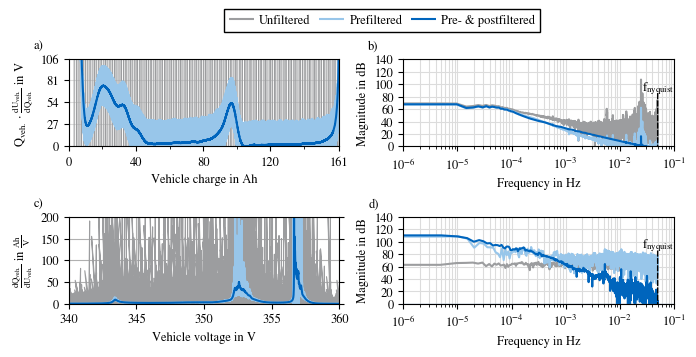

In [31]:
nrows = 2
heigth = 4 #cm
fig, axes= plt.subplots(nrows,2,layout="constrained",
                        figsize=(VisualizationConfig.textwidth_in_in.value,
                                nrows*cm2inch(heigth)))
axes = axes.flatten()

shift=1.9 #better visibility
axes[0] = DVA_plot_v(axes[0],
              cap_raw_v[0::100]+shift ,dva_raw_v[0::100],
              cap_pre_filt_v+shift, dva_pre_filt_v,
              cap_filt_v+shift, dva_filt_v)

axes[1] = DVA_bode_plot_v(axes[1],freq_raw = DVA_raw_v[2], mag_raw = DVA_raw_v[1],
                    freq_pre_filt = DVA_pre_filt_v[2], mag_pre_filt = DVA_pre_filt_v[1],
                    freq_filt = DVA_filt_v[2], mag_filt = DVA_filt_v[1])



axes[2] = ICA_plot_v(axes[2],
              volt_raw_v[10::] ,ica_raw_v[10::],
              volt_pre_filt_v, ica_pre_filt_v,
              volt_filt_v, ica_filt_v)

axes[3] = ICA_bode_plot_v(axes[3],freq_raw = ICA_raw_v[2], mag_raw = ICA_raw_v[1],
                    freq_pre_filt = ICA_pre_filt_v[2], mag_pre_filt = ICA_pre_filt_v[1],
                    freq_filt = ICA_filt_v[2], mag_filt = ICA_filt_v[1])

prop=dict(facecolor='white', alpha=1, linewidth=0,pad=0.1)
axes[0].text(-0.11, 1.15, r'a)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes[0].transAxes)
axes[1].text(-0.11, 1.15, r'b)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes[1].transAxes)
axes[2].text(-0.11, 1.15, r'c)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes[2].transAxes)
axes[3].text(-0.11, 1.15, r'd)', horizontalalignment='center',fontsize=9,
     verticalalignment='center', transform=axes[3].transAxes)



# ## Markers
axes[1].text(0.05,90,r"$f_{nyquist}$",horizontalalignment='center',fontsize=9,bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0))
axes[1].annotate(text='', xy=(0.05,0), xytext=(0.05,85), arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k",linestyle="--"))
axes[3].text(0.05,90,r"$f_{nyquist}$",horizontalalignment='center',fontsize=9,bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0))
axes[3].annotate(text='', xy=(0.05,0), xytext=(0.05,85), arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k",linestyle="--"))

# ### Legend
# legend must be after tight layout
handles, labels =axes[0].get_legend_handles_labels()  
line = plt.hlines(-1,0,1,label='Unfiltered',color=VisualizationConfig.TUMgrau50.value)
line2 = plt.hlines(-1,0,1,label='Prefiltered', color=VisualizationConfig.TUMhellblau.value)
line3 = plt.hlines(-1,0,1,label='Pre- & postfiltered', color=VisualizationConfig.TUMblau.value)

# add manual symbols to auto legend
handles.extend([line, line2, line3])
lgd = fig.legend(handles=handles,loc="center",fontsize=9,ncols=3,handletextpad=0.4,
           framealpha =1 , fancybox=False,labelspacing=0,columnspacing=0.7,edgecolor="black",bbox_to_anchor=(0.55, 1.05))
#plt.tight_layout()
fig.savefig(os.path.join(GeneralConfig.path2figures.value,"02-DVA_ICA_Frequency_Plot_Tesla.pdf"),bbox_inches="tight") 
fig.savefig(os.path.join(GeneralConfig.path2figures.value,"02-DVA_ICA_Frequency_Plot_Tesla.png"),dpi=300,bbox_inches="tight") 